In [23]:
import statistics
import tqdm
import torch
import art
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from art.utils import load_mnist
import torchvision
from matplotlib import pyplot as plt
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from art.estimators.classification import PyTorchClassifier

device = "cuda:0" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(device)

cpu


### Model Setup

In [13]:
# some part of the code are from the ART tutorials https://github.com/Trusted-AI/adversarial-robustness-toolbox/blob/main/examples/get_started_pytorch.py#L68

batch_size = 64
num_classes = 10
epochs = 5

In [24]:
(x_train, y_train), (x_test, y_test), min_pixel_value, max_pixel_value = load_mnist()
x_train = np.transpose(x_train, (0, 3, 1, 2)).astype(np.float32)
x_test = np.transpose(x_test, (0, 3, 1, 2)).astype(np.float32)

In [15]:
# Feed Forward Neural Network

# model architecture from: https://www.kaggle.com/code/pankajj/fashion-mnist-with-pytorch-93-accuracy

class Classifier(nn.Module):
    def __init__(self, num_classes: int, activation_function=nn.ReLU(), loss_fn=nn.CrossEntropyLoss()):
        super().__init__()
        self.conv_layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            activation_function,
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv_layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            activation_function,
            nn.MaxPool2d(2)
        )
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(64 * 6 * 6, 600),
            nn.Dropout(0.25),
            activation_function,
            nn.Linear(600, 120),
            activation_function,
            nn.Linear(120, num_classes)  # no softmax necessary
        )

        self.num_classes = num_classes
        self.loss_fn = loss_fn

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv_layer1(x)
        x = self.conv_layer2(x)
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

    def train_network(self, dataloader: DataLoader, optimizer: torch.optim.Optimizer):
        self.train()
        losses = []
        for batch, (X, y) in enumerate(tqdm.tqdm(dataloader)):
            X, y = X.to(device), y.to(device)

            # Compute prediction error
            y_pred = self.forward(X)
            y_true = F.one_hot(y, self.num_classes).type(y_pred.dtype)
            loss = self.loss_fn(y_pred, y_true)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            losses.append(loss.item())
        print(f"Epoch Train Loss: {statistics.mean(losses)}")

    def test(self, dataloader: DataLoader):
        num_batches = len(dataloader)
        self.eval()
        test_loss = 0

        num_correct = 0
        with torch.no_grad():
            for X, y in dataloader:
                X, y = X.to(device), y.to(device)
                y_pred = self.forward(X)
                test_loss += self.loss_fn(y_pred, F.one_hot(y, self.num_classes).type(y_pred.dtype)).item()
                num_correct += (torch.argmax(y_pred, dim=1) == y).sum().item()
        test_loss /= num_batches
        accuracy = num_correct / len(dataloader.dataset)
        print(f"Test Error: Avg loss: {test_loss:>8f} Accuracy: {float(accuracy):>8f} \n")

In [25]:
model = Classifier(num_classes=num_classes).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)



In [26]:
criterion = nn.CrossEntropyLoss()

classifier = PyTorchClassifier(
    model=model,
    clip_values=(min_pixel_value, max_pixel_value),
    loss=criterion,
    optimizer=optimizer,
    input_shape=(1, 28, 28),
    nb_classes=10,
)

In [27]:
"""for t in range(epochs):
    print(f"Epoch {t+1} -------------------------------")
    model.train_network(train_loader, optimizer)
    model.test(test_loader)"""
classifier.fit(x_train, y_train, batch_size=64, nb_epochs=3)

### Attacks

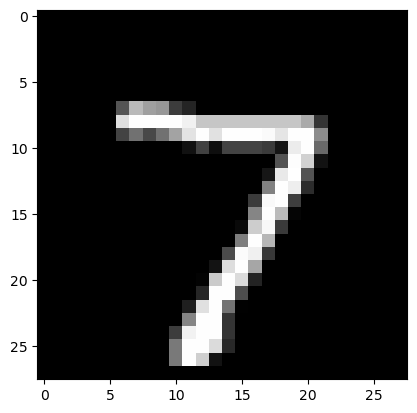

In [38]:
def showImage(image):
    plt.imshow(image[0], cmap='gray', interpolation='none')
    plt.show()
showImage(x_test[0])

In [39]:
predictions = classifier.predict(x_test)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on benign test examples: {}%".format(accuracy * 100))

Accuracy on benign test examples: 99.02%


### Fast Graident Sign Method

In [30]:
# Fast Gradient Method
attack = art.attacks.evasion.FastGradientMethod(estimator=classifier, eps=0.2)
x_test_adv = attack.generate(x=x_test)

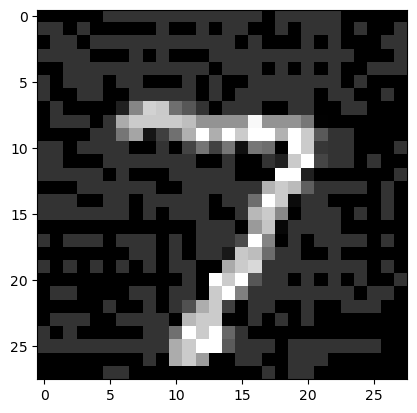

In [37]:
showImage(x_test_adv[0])

In [31]:
predictions = classifier.predict(x_test_adv)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print("Accuracy on adversarial test examples: {}%".format(accuracy * 100))

Accuracy on adversarial test examples: 36.26%
